# Atividade 04 - Implementação de uma ELM

Implementar e testar ELM simples. A implementação da ELM deve ser a mais simples possível. Gostaria de uma implementação bem minimalista, implementando somente os métodos essenciais. O teste deve seguir o formato de apresentação da comparação de classificadores do Scikit Learn, mas as bases e o conjunto de classificadores a serem testados serão diferentes. 

Classificadores a serem testados:

    Perceptron
    MLPClassifier
    E a ELM que você implementar

Todos os classificadores utilizarão seus parâmetros default.

Bases a serem criadas e testadas:

    Duas bases utilizando make_classification:
        uma base com mais exemplos do que características
        outra base com mais características do que exemplos
    Duas bases utilizando make_gaussian_quantiles:
        uma base com mais exemplos do que características
        outra base com mais características do que exemplos

Todas as bases terão seus valores default, exceto pelo número de exemplos e de características.

A tarefa deve ser entregue na forma um link para um Jupyter Notebook (ou Colab) em seu perfil no GitHub e deve conter:

    Os plots do meshgrid dos 3 classificadores com as 4 bases
    Uma tabela com a validação cruzada dos classificadores e as bases com média e desvio padrão da acurácia e do tempo de treinamento
    Um texto analisando os resultados obtidos


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification, make_gaussian_quantiles
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

## Classificador ELM e plots do meshgrid

Observação: somente consegui gerar os meshgrid quando n_features = 2.

In [2]:
from scipy.special import expit
class ELMClassifier(BaseEstimator, ClassifierMixin):
    """Ref. LinearMachine&ELM&Experimenter Prof. Boldt 2019 (Rec Padrões)"""
    def __init__(self, factor=5):
        self.factor = factor
    def fit(self, X, y=None):
        X_b = np.hstack((np.ones((X.shape[0],1)),X))
        self.inputW = np.random.rand(X_b.shape[1], X_b.shape[1]*self.factor)*2-1
        hidden = expit(np.matmul(X_b,self.inputW))
        if len(set(y)) > 2:
            y = LabelBinarizer().fit_transform(y)
        self.outputW = np.matmul(np.linalg.pinv(hidden),y*2-1)
    def predict(self, X, y=None):
        resp = self.decision_function(X, y)
        if len(resp.shape)>1:
            resp = np.argmax(resp,axis=1)
        else:
            resp = resp>0
        return resp
    def decision_function(self, X, y=None):
        X_b = np.hstack((np.ones((X.shape[0],1)),X))
        hidden = expit(np.matmul(X_b,self.inputW))
        df = np.matmul(hidden,self.outputW)
        return np.tanh(df)

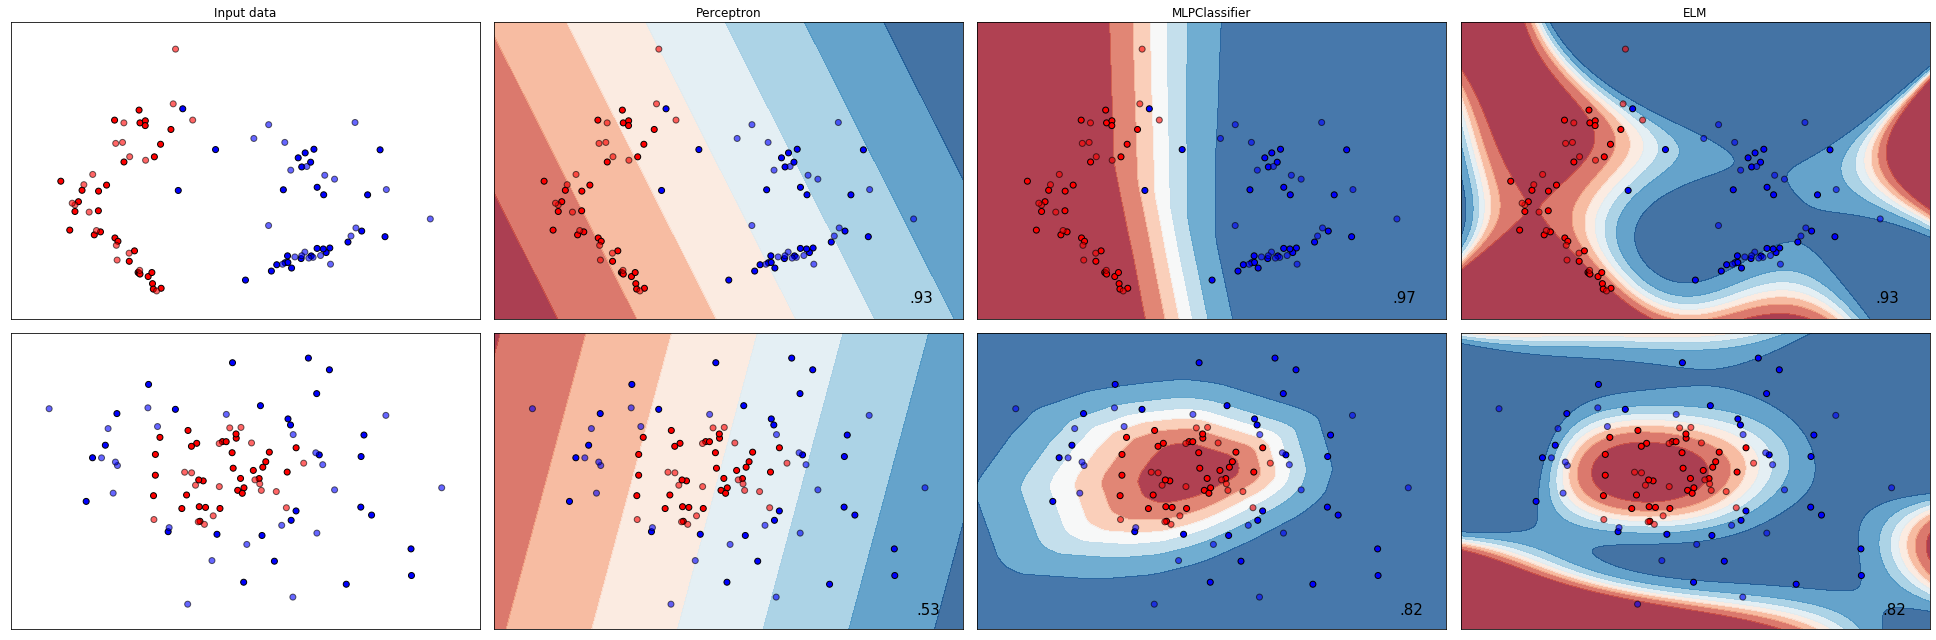

In [3]:
h = .02  # step size in the mesh

names = ["Perceptron", "MLPClassifier", "ELM"]

classifiers = [
    Perceptron(),
    MLPClassifier(alpha=1, max_iter=1000),
    ELMClassifier(5)]

datasets = [make_classification(n_samples=100, n_features=2, n_redundant=0, n_informative=2,
                    random_state=1, n_clusters_per_class=2),
            make_gaussian_quantiles(n_samples=100, n_features=2, n_classes=2, 
                    shuffle=True, random_state=1)
            ]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=1)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

## Tabela com validação cruzada e acurácia

In [4]:
from sklearn.model_selection import KFold
from scipy.sparse import coo_matrix
from sklearn.utils import shuffle
import numpy as np

class PerformanceEvaluator():
    """Ref. LinearMachine&ELM&Experimenter Prof. Boldt 2019 (Rec Padrões)"""
    def __init__(self, X, y):
        X_sparse = coo_matrix(X)
        self.X, X_sparse, self.y = shuffle(X, X_sparse, y)
        self.kf = KFold(5)
    def folds(self, clf):
        folds = []
        for train_index, test_index in self.kf.split(self.X, self.y):
            clf.fit(self.X[train_index],self.y[train_index])
            folds.append(clf.score(self.X[test_index],self.y[test_index]))
        return folds
    def score(self, clf):
        return np.mean(self.folds(clf))

class Experimenter():
    """Ref. LinearMachine&ELM&Experimenter Prof. Boldt 2019 (Rec Padrões)"""
    def __init__(self):
        self.datasets = []
        self.predictors = []
    def addDataset(self, dataset):
        self.datasets.append(dataset)
    def addPredictor(self, predictor):
        self.predictors.append(predictor)
    def perform(self):
        print('\t\t\t', end='| ')
        for predname, pred in self.predictors:
              print(predname, end='\t\t| ')
        print()
        for dsn, X, y in self.datasets:
            print(dsn , end='\t| ')
            pe = PerformanceEvaluator(X,y)
            for predname, pred in self.predictors:
                    score = pe.score(pred)
                    print('{0:.5f}'.format(score), end='\t\t| ')
            print()

exp = Experimenter()
exp.addPredictor(('Perceptron', Perceptron()))
exp.addPredictor(('MLP Classifier', MLPClassifier(alpha=1, max_iter=1000)))
exp.addPredictor(('ELM', ELMClassifier(5)))

X1, y1 = make_classification(n_samples=100, n_features=2, n_redundant=0, n_informative=2,
                    random_state=1, n_clusters_per_class=2)
exp.addDataset(('Make Classification', X1, y1))

X2, y2 = make_gaussian_quantiles(n_samples=100, n_features=2, n_classes=2, 
                    shuffle=True, random_state=1)
exp.addDataset(('Make Gaussian\t', X2, y2))

exp.perform()

			| Perceptron		| MLP Classifier		| ELM		| 
Make Classification	| 0.97000		| 0.98000		| 0.96000		| 
Make Gaussian		| 0.48000		| 0.93000		| 0.95000		| 


## Texto com análise

Os resultados obtidos nos dados gerados pelo make_classification obtiveram melhores resultados que nos dados gerados pelo make_gaussian_quantiles.

O Perceptron não obteve o melhor resultado em nenhuma das bases.

Na base gerada pelo make_classification o MLP Classifier obteve um resultado ligeiramente melhor que o ELM.

Na base gerada pelo make_gaussian_quantiles o ELM obteve um resultado ligeiramente melhor que o MLP Classifier.